In [ ]:
!pip install transformers datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


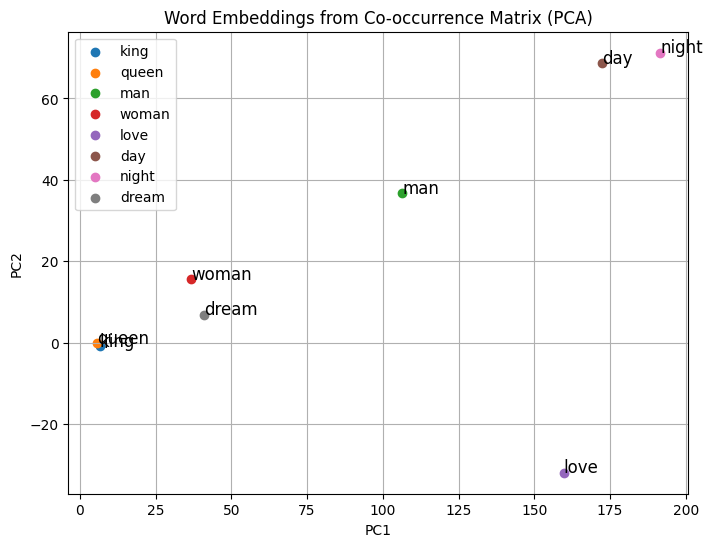

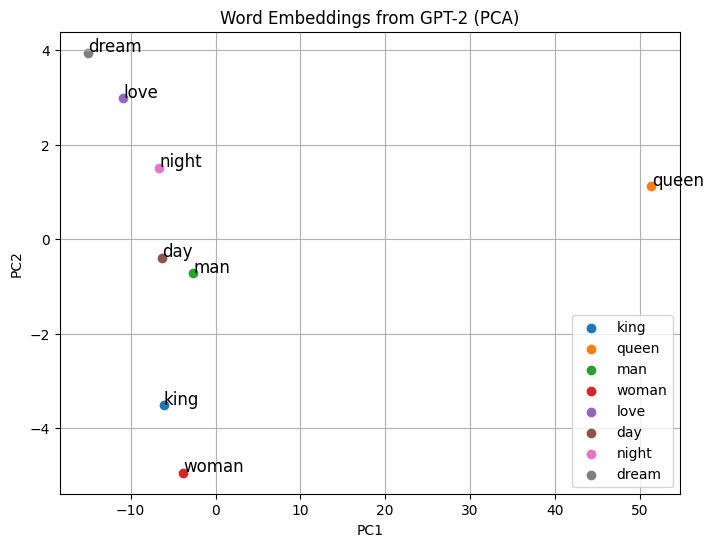

Co-occurrence Matrix Similarities:
{'king-queen': 0.9947841658740229, 'king-man': 0.8940472934563976, 'king-woman': 0.8602274774537332, 'king-love': 0.99787773951727, 'king-day': 0.8720493065956004, 'king-night': 0.8831847417446338, 'king-dream': 0.9558340917674418, 'queen-man': 0.9350783121875775, 'queen-woman': 0.9077526996220925, 'queen-love': 0.9860310547618084, 'queen-day': 0.9174225925527958, 'queen-night': 0.9264198402863811, 'queen-dream': 0.9808277776728659, 'man-woman': 0.9975099592573266, 'man-love': 0.8629799724376638, 'man-day': 0.9988991818902114, 'man-night': 0.9997193945351784, 'man-dream': 0.9862230579608753, 'woman-love': 0.8251988199836249, 'woman-day': 0.9997201521113668, 'woman-night': 0.998900682584835, 'woman-dream': 0.9721008883633241, 'love-day': 0.8383299338702198, 'love-night': 0.8507696190693114, 'love-dream': 0.934667702260082, 'day-night': 0.9997300689123128, 'day-dream': 0.9773777285924726, 'night-dream': 0.9820277898164321}

GPT-2 Embedding Similarities:

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import re
from collections import Counter
import json
from sklearn.metrics.pairwise import cosine_similarity
from transformers import AutoTokenizer, AutoModel
import torch

# Load the cleaned poems
with open("/content/cleaned_ppoems.json", 'r') as f:
    cleaned_ppoems = [json.loads(line) for line in f]

# Extracting sentences from data
sentences = []
for poem in cleaned_ppoems:
    body = poem['body']
    poem_sentences = re.split(r'[.!?]', body)  # Split into sentences
    sentences.extend([sentence.strip() for sentence in poem_sentences if sentence.strip()])

# making our dataset shorter
sentences = sentences[:10000]

# Preprocessing
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    return text.split()

# Tokenize the sentences
tokenized_sentences = [preprocess_text(sentence) for sentence in sentences]

# Build Vocabulary
vocab = set(word for sentence in tokenized_sentences for word in sentence)
word_to_index = {word: idx for idx, word in enumerate(vocab)}
index_to_word = {idx: word for word, idx in word_to_index.items()}

# Create Co-occurrence Matrix
def build_cooccurrence_matrix(tokenized_sentences, vocab_size, window_size=2):
    co_matrix = np.zeros((vocab_size, vocab_size))
    for sentence in tokenized_sentences:
        for i, word in enumerate(sentence):
            center_idx = word_to_index[word]
            for j in range(max(0, i - window_size), min(len(sentence), i + window_size + 1)):
                if i != j:
                    context_idx = word_to_index[sentence[j]]
                    co_matrix[center_idx, context_idx] += 1
    return co_matrix

vocab_size = len(vocab)
co_matrix = build_cooccurrence_matrix(tokenized_sentences, vocab_size)

# Apply PCA
pca = PCA(n_components=2)
reduced_embeddings_cooccurrence = pca.fit_transform(co_matrix)

# Selecting Words for Visualization
selected_words = ["king", "queen", "man", "woman", "love", "day", "night", "dream"]
selected_indices = [word_to_index[word] for word in selected_words if word in word_to_index]
selected_embeddings_cooccurrence = reduced_embeddings_cooccurrence[selected_indices]

# Visualization for Co-occurrence Matrix
plt.figure(figsize=(8, 6))
for idx, word in zip(selected_indices, selected_words):
    plt.scatter(reduced_embeddings_cooccurrence[idx, 0], reduced_embeddings_cooccurrence[idx, 1], label=word)
    plt.text(reduced_embeddings_cooccurrence[idx, 0] + 0.02, reduced_embeddings_cooccurrence[idx, 1] + 0.02, word, fontsize=12)

plt.title("Word Embeddings from Co-occurrence Matrix (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.grid()
plt.show()

# Initialize Hugging Face GPT-2 model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("gpt2")
model = AutoModel.from_pretrained("gpt2")

# Function to get word embeddings from GPT-2
def get_word_embedding(word):
    inputs = tokenizer(word, return_tensors="pt")
    outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).detach().numpy()

embeddings_gpt2 = {word: get_word_embedding(word) for word in selected_words}

embedding_matrix_gpt2 = np.vstack(list(embeddings_gpt2.values()))
reduced_embeddings_gpt2 = pca.fit_transform(embedding_matrix_gpt2)

# Visualization for GPT-2 Embeddings
plt.figure(figsize=(8, 6))
for idx, word in enumerate(selected_words):
    plt.scatter(reduced_embeddings_gpt2[idx, 0], reduced_embeddings_gpt2[idx, 1], label=word)
    plt.text(reduced_embeddings_gpt2[idx, 0] + 0.02, reduced_embeddings_gpt2[idx, 1] + 0.02, word, fontsize=12)

plt.title("Word Embeddings from GPT-2 (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.grid()
plt.show()

# Compare Similarities Between Embeddings
def compute_similarities(embeddings, words):
    similarities = {}
    for i, word1 in enumerate(words):
        for j, word2 in enumerate(words):
            if i < j:
                sim = cosine_similarity(embeddings[word1], embeddings[word2])
                similarities[f"{word1}-{word2}"] = sim[0, 0]
    return similarities

# Compute similarities for Co-occurrence and GPT-2 Embeddings
similarities_cooccurrence = compute_similarities(
    {word: reduced_embeddings_cooccurrence[idx].reshape(1, -1) for idx, word in zip(selected_indices, selected_words)},
    selected_words
)

similarities_gpt2 = compute_similarities(
    {word: embeddings_gpt2[word] for word in selected_words},
    selected_words
)

print("Co-occurrence Matrix Similarities:")
print(similarities_cooccurrence)
print("\nGPT-2 Embedding Similarities:")
print(similarities_gpt2)